In [1]:
#https://github.com/rohansawant7978/grammar_correction/blob/main/04%20Make%20data%20model%20ready.ipynb
import zipfile
import pandas as pd
import numpy as np
import re
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.layers import Embedding, LSTM, Dense,RNN
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tqdm import tqdm
from sklearn.model_selection import train_test_split
import seaborn as sns
import os
from datetime import datetime
import pytz
from tensorflow.keras.callbacks import LearningRateScheduler,TensorBoard,ReduceLROnPlateau
from tensorflow.keras.optimizers import Adam,Nadam
import warnings
warnings.filterwarnings('ignore')
import nltk.translate.bleu_score as bleu
import random
from tqdm import tqdm
import shutil
import io
from nltk.translate.gleu_score import sentence_gleu
import pickle

In [2]:
df = pd.read_csv('explored_csv03.csv')

In [3]:
df = df[df['tgt_word_count'] <= 30]
df.shape

(135192, 10)

In [4]:
df = df[['src','tgt']]

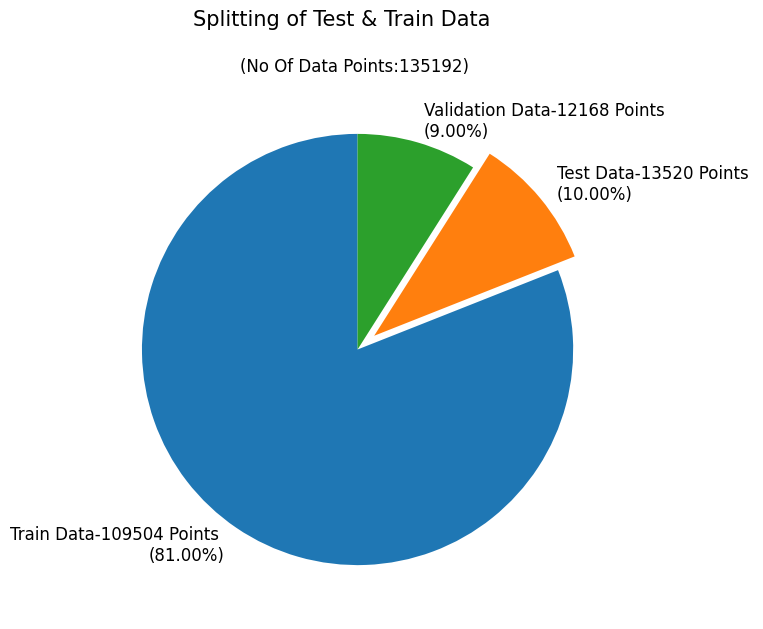

In [5]:
train,test = train_test_split(df, test_size=0.1,random_state=15)
train,validation = train_test_split(train, test_size=0.1)
fig,ax = plt.subplots(figsize =(10, 7))
labels_split = ['Train', 'Test','Validation'] 
sizes_split = [len(train),len(test),len(validation)]
pcts_split = [f'{l} Data-{s} Points \n({s*100/sum(sizes_split):.2f}%)' for s,l in zip(sizes_split, labels_split)] 
ax.pie(sizes_split, labels = pcts_split, startangle = 90, 
       explode=(0,0.1,0),textprops = {"fontsize":12} )

plt.suptitle(f'Splitting of Test & Train Data ', fontsize = 15)
plt.title(f'(No Of Data Points:{sum(sizes_split)}) ', fontsize = 12)
plt.show()

In [6]:
train['dec_src_inp'] = '<start> ' + train['src']
train['dec_src_out'] = train['src'] + ' <end>'

validation['dec_src_inp'] = '<start> ' + validation['src']
validation['dec_src_out'] = validation['src'] + ' <end>'

test['dec_src_inp'] = '<start> ' + test['src']
test['dec_src_out'] = test['src'] + ' <end>'
train.sample(5)

,src,tgt,dec_src_inp,dec_src_out
130900,entitled ‘Welcome to the 'Islamic State' land .,Titled 'Welcome to the land of the Islamic Sta...,<start> entitled ‘Welcome to the 'Islamic Stat...,entitled ‘Welcome to the 'Islamic State' land ...
43701,"Rather , it means that , if ""T"" is false , the...","If ""T"" is untrue , it is possible to demonstra...","<start> Rather , it means that , if ""T"" is fal...","Rather , it means that , if ""T"" is false , the..."
56264,RMIT University was also ranked among the top ...,RMIT University was placed in the top 51-100 u...,<start> RMIT University was also ranked among ...,RMIT University was also ranked among the top ...
111616,Carr of Big Brother Watch said: ‘It is time th...,Carr from Big Brother Watch stated that it is ...,<start> Carr of Big Brother Watch said: ‘It is...,Carr of Big Brother Watch said: ‘It is time th...
84071,where the text adopted does not correctly refl...,When the adopted text fails to accurately repr...,<start> where the text adopted does not correc...,where the text adopted does not correctly refl...


In [7]:
validation.sample(5)

,src,tgt,dec_src_inp,dec_src_out
69151,The first docking of Soviet spacecraft was fin...,"In January 1969 , the Soyuz 4 and Soyuz 5 miss...",<start> The first docking of Soviet spacecraft...,The first docking of Soviet spacecraft was fin...
115691,This helps to create the .,The creation of the is facilitated by this .,<start> This helps to create the .,This helps to create the . <end>
35348,The boxer Mike Tyson had most of his fights in...,Atlantic City gained national recognition as a...,<start> The boxer Mike Tyson had most of his f...,The boxer Mike Tyson had most of his fights in...
121129,that early intelligence reporting about the at...,The initial intelligence reports regarding the...,<start> that early intelligence reporting abou...,that early intelligence reporting about the at...
63168,The 2010 Human Development Report was the firs...,The Inequality-adjusted Human Development Inde...,<start> The 2010 Human Development Report was ...,The 2010 Human Development Report was the firs...


In [8]:
test.sample(5)

,src,tgt,dec_src_inp,dec_src_out
114343,Ever since the superstar songstress released h...,Since the release of the unexpected self-title...,<start> Ever since the superstar songstress re...,Ever since the superstar songstress released h...
71972,This new power destabilized the European balan...,"The European balance of power , which was esta...",<start> This new power destabilized the Europe...,This new power destabilized the European balan...
89773,The prince-bishopric was involved in almost co...,The prince-bishopric engaged in frequent dispu...,<start> The prince-bishopric was involved in a...,The prince-bishopric was involved in almost co...
81589,He outlined his Third International Theory tha...,The Green Book was where he published his Thir...,<start> He outlined his Third International Th...,He outlined his Third International Theory tha...
171588,In rural areas it was ever higher at one in two .,"The rate was even higher in rural regions , re...",<start> In rural areas it was ever higher at o...,In rural areas it was ever higher at one in tw...


In [9]:
train.to_csv('train.csv')
validation.to_csv('val.csv')
test.to_csv('test.csv')

In [10]:
tokenizer_enc = Tokenizer(filters='#$%&()*+/=?@[\]^_`{|}~\t\n',lower=False)
tokenizer_enc.fit_on_texts(train['tgt'].values)

In [11]:
tokenizer_dec = Tokenizer(filters='#$%&()*+/=?@[\]^_`{|}~\t\n',lower=False)
tokenizer_dec.fit_on_texts(train['dec_src_inp'].values)

In [12]:
vocab_size_enc=len(tokenizer_enc.word_index.keys())
print('Encoder words vocab size:',vocab_size_enc)

Encoder words vocab size: 89772


In [13]:
vocab_size_dec=len(tokenizer_dec.word_index.keys())
print('Decoder words vocab size:',vocab_size_dec)

Decoder words vocab size: 106745


In [14]:
dec_wordindex = tokenizer_dec.word_index
dec_wordindex['<end>'] = max(tokenizer_dec.word_index.values()) + 1

In [15]:
tokenizer_dec.word_index['<end>']

106746

In [16]:
tokenizer_dec.word_index.keys()

dict_keys(['.', 'the', '<start>', ',', 'of', 'and', 'to', 'in', 'a', 'The', 'is', 'was', 'for', 'that', 'as', 'on', "'s", 'with', 'by', 'are', 'from', 'at', 'his', 'be', 'were', 'it', 'has', 'have', 'an', 'he', 'not', 'had', 'which', 'their', 'In', 'or', 'also', 'been', 'her', 'said', 'they', 'but', 'who', 'this', 'after', 'its', 'one', 'more', 'It', 'she', 'into', 'I', 'A', 'other', 'will', 'can', 'when', 'than', 'first', 'He', 'would', 'up', 'all', 'two', 'about', 'time', 'out', '"', 'most', 'over', 'such', 'This', 'some', 'people', 'used', 'only', 'years', 'there', 'during', 'new', 'many', 'them', 'him', 'between', 'being', 'could', 'no', 'city', 'year', 'made', '-', '000', 'But', 'may', 'where', 'before', 'last', 'so', 'home', 'three', 'United', 'while', 'through', 'these', 'found', 'do', 'state', 'now', 'because', 'did', 'known', 'then', 'use', 'called', 'you', 'world', 'just', 'against', 'New', 'They', 'under', 'what', 'government', 'any', 'Mr', 'around', 'later', 'left', 'part',

In [18]:
dec_wordindex['<start>'] = 1
dec_wordindex['.'] = 3

In [19]:
tokenizer_dec.word_index['<start>']

1

In [20]:
vocab_size_dec=len(tokenizer_dec.word_index.keys())
print('Decoder words vocab size:',vocab_size_dec)

Decoder words vocab size: 106746


In [21]:
with open('tokenizer_enc.pkl', 'wb') as f:
  pickle.dump(tokenizer_enc, f)

with open('tokenizer_dec.pkl', 'wb') as f:
  pickle.dump(tokenizer_dec, f)

In [22]:
#text2seq
train_enc_inp = tokenizer_enc.texts_to_sequences(train['tgt'].astype(str).values)
validation_enc_inp = tokenizer_enc.texts_to_sequences(validation['tgt'].astype(str).values)
test_enc_inp = tokenizer_enc.texts_to_sequences(test['src'].astype(str).values)

#padding
max_seq_len = 30
train_enc_inp = pad_sequences(train_enc_inp, maxlen=max_seq_len, padding='post', truncating='post')
validation_enc_inp = pad_sequences(validation_enc_inp, maxlen=max_seq_len, padding='post', truncating='post')

#text2seq
train_dec_inp = tokenizer_dec.texts_to_sequences(train['dec_src_inp'].astype(str).values)
validation_dec_inp = tokenizer_dec.texts_to_sequences(validation['dec_src_inp'].astype(str).values)

#padding
train_dec_inp = pad_sequences(train_dec_inp, maxlen=max_seq_len+1, padding='post', truncating='post')
validation_dec_inp = pad_sequences(validation_dec_inp, maxlen=max_seq_len+1, padding='post', truncating='post')

#text2seq
train_dec_out = tokenizer_dec.texts_to_sequences(train['dec_src_out'].astype(str).values)
validation_dec_out = tokenizer_dec.texts_to_sequences(validation['dec_src_out'].astype(str).values)

#padding
train_dec_out = pad_sequences(train_dec_out, maxlen=max_seq_len+1, padding='post', truncating='post')
validation_dec_out = pad_sequences(validation_dec_out, maxlen=max_seq_len+1, padding='post', truncating='post')

Mean Word Count:19.43885154880187


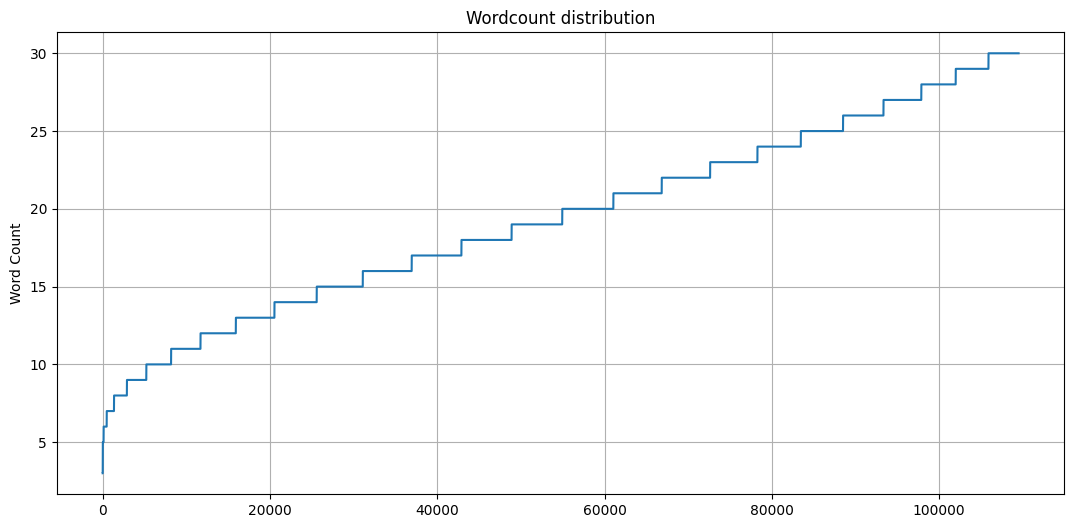

In [23]:
content=train['tgt']
content_word_count=[len(content.iloc[i].split()) for i in range(len(content))]
mean_word_count=np.mean(content_word_count)
print(f'Mean Word Count:{mean_word_count}')
index=[i for i in range(0,len(content_word_count))]
fig, ax=plt.subplots(figsize=(13, 6))
plt.plot(index,sorted(content_word_count))
plt.grid()
plt.title("Wordcount distribution")
plt.ylabel("Word Count")
plt.show()

In [24]:
#text2seq
train_enc_inp = tokenizer_enc.texts_to_sequences(train['tgt'].astype(str).values)
validation_enc_inp = tokenizer_enc.texts_to_sequences(validation['tgt'].astype(str).values)
test_enc_inp = tokenizer_enc.texts_to_sequences(test['tgt'].astype(str).values)

#padding
max_seq_len = 30
train_enc_inp = pad_sequences(train_enc_inp, maxlen=max_seq_len, padding='post', truncating='post')
validation_enc_inp = pad_sequences(validation_enc_inp, maxlen=max_seq_len, padding='post', truncating='post')
test_enc_inp = pad_sequences(test_enc_inp, maxlen=max_seq_len, padding='post', truncating='post')

In [25]:
#text2seq
train_dec_inp = tokenizer_dec.texts_to_sequences(train['dec_src_inp'].astype(str).values)
validation_dec_inp = tokenizer_dec.texts_to_sequences(validation['dec_src_inp'].astype(str).values)
test_dec_inp = tokenizer_dec.texts_to_sequences(test['dec_src_inp'].astype(str).values)

#padding
train_dec_inp = pad_sequences(train_dec_inp, maxlen=max_seq_len+1, padding='post', truncating='post')
validation_dec_inp = pad_sequences(validation_dec_inp, maxlen=max_seq_len+1, padding='post', truncating='post')
test_dec_inp = pad_sequences(test_dec_inp, maxlen=max_seq_len+1, padding='post', truncating='post')

In [26]:
#text2seq
train_dec_out = tokenizer_dec.texts_to_sequences(train['dec_src_out'].astype(str).values)
validation_dec_out = tokenizer_dec.texts_to_sequences(validation['dec_src_out'].astype(str).values)
test_dec_out = tokenizer_dec.texts_to_sequences(test['dec_src_out'].astype(str).values)

#padding
train_dec_out = pad_sequences(train_dec_out, maxlen=max_seq_len+1, padding='post', truncating='post')
validation_dec_out = pad_sequences(validation_dec_out, maxlen=max_seq_len+1, padding='post', truncating='post')
test_dec_out = pad_sequences(test_dec_out, maxlen=max_seq_len+1, padding='post', truncating='post')

In [27]:
with open('train_enc_inp.pkl', 'wb') as f:
  pickle.dump(train_enc_inp, f)

with open('val_enc_inp.pkl', 'wb') as f:
  pickle.dump(validation_enc_inp, f)

with open('test_enc_inp.pkl', 'wb') as f:
  pickle.dump(test_enc_inp, f)

In [28]:
with open('train_dec_inp.pkl', 'wb') as f:
  pickle.dump(train_dec_inp, f)

with open('val_dec_inp.pkl', 'wb') as f:
  pickle.dump(validation_dec_inp, f)

with open('test_dec_inp.pkl', 'wb') as f:
  pickle.dump(test_dec_inp, f)

In [29]:
with open('train_dec_out.pkl', 'wb') as f:
  pickle.dump(train_dec_out, f)

with open('val_dec_out.pkl', 'wb') as f:
  pickle.dump(validation_dec_out, f)

with open('test_dec_out.pkl', 'wb') as f:
  pickle.dump(test_dec_out, f)
